In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00


In [2]:
#@title Imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
%matplotlib inline

import numpy as np
import pandas as pd
import os 

import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = tf.keras.models.load_model("/content/drive/My Drive/Project_cs210/trained_model")
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

##Open the File that containts content and True Labels 

In [7]:
project_path = "/content/drive/My Drive/Project_cs210/sorted_news/"

# List the folders in the dataset directory
folder_names = ['neg', 'pos']

# Prepare empty lists to store the data and labels
data = []
file_names = [] 
labels = []

# Iterate through the folders
for folder_name in folder_names:
    folder_path = os.path.join(project_path, folder_name)

    # Iterate through the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Read the contents of the file with the appropriate encoding
        with open(file_path, 'r', encoding='iso-8859-9') as file:
            contents = file.read()
        file_names.append(filename)
        # Append the contents to the data list
        data.append(contents)

        # Append the corresponding label (0 for 'neg' and 1 for 'pos')
        labels.append(0 if folder_name == 'neg' else 1)
# Print the first few samples to verify the data and labels
for text, label in zip(data[:5], labels[:5]):
    print(f"Label: {label}, Text: {text}")


Label: 0, Text: BIST-100 dün yatay kapanış gerçekleştirdi. Hafta başından bu yana olumsuz yönde ayrışan banka hisseleri endeksin tutunmasına destek verirken, ayrıca otomotiv ve perakende hisselerinde de olumlu ayrışma gözledik. Buna karşılık geride kalan alt sektörlerin pek çoğunda satış baskısı devam etti. Bilanço beklentilerine bağlı hisse bazlı hareketler ile BIST-100deki sıkışık seyrin bir süre daha devamını bekliyoruz.
Label: 0, Text: Piyasa dün beklentiler paralelinde sert bir düzeltme gerçekleştirdi ve pek çok hissenin taban fiyat seviyelerinden alıcılı bulamadığı bir seansın ardından BIST-100 endeksi günü %10 kayıpla tamamladı. Yurt dışı tarafta ise ABD tahvil faizlerinde hafif bir gerileme ve ABD hisselerinde ılımlı bir yükseliş gözlendi. Bu sabah işlemlerinde yurt dışı hisse senetleri tarafı nispeten sakin, yurt içinde ise kur ve faiz seviyeleri dünkü kapanışlarına yakın görünüyor. Dünkü sert düşüşün ardından BISTde dengelenme çabasının bugün de sürmesini ve endeksin güne b

In [8]:
data_dict = {"Content": data, "Folder_Name": file_names, "True_Label": labels}
df = pd.DataFrame(data_dict)

In [9]:
df.head()

,Content,Folder_Name,True_Label
0,BIST-100 dün yatay kapanış gerçekleştirdi. Haf...,akbank_28.04.2023_18.txt,0
1,Piyasa dün beklentiler paralelinde sert bir dü...,akbank_23.03.2021_522.txt,0
2,"Dün özellikle telekom, banka ve savunma sanayi...",akbank_25.11.2021_362.txt,0
3,Geçtiğimiz hafta Covid-19a ilişkin endişeler ...,akbank_01.02.2021_558.txt,0
4,Geçtiğimiz hafta küresel piyasalarda risk işta...,akbank_13.09.2021_413.txt,0


## Make Predictions for the whole data

In [24]:
# Extract sentences and true labels from the 'DATA_COLUMN' and 'LABEL_COLUMN' of the `test` dataframe
sentences = df['Content'].tolist()
true_labels = df['True_Label'].tolist()

# Tokenize the input sentences
tf_batch = tokenizer(sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')

# Make predictions
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)
labels = ['Negative', 'Positive']
predicted_labels = tf.argmax(tf_predictions, axis=1).numpy()

# Create a new DataFrame with the text value, true value, and predicted value
results_df = pd.DataFrame({'Content': sentences, "File Name": file_names, 'True Value': true_labels, 'Predicted Value': predicted_labels})

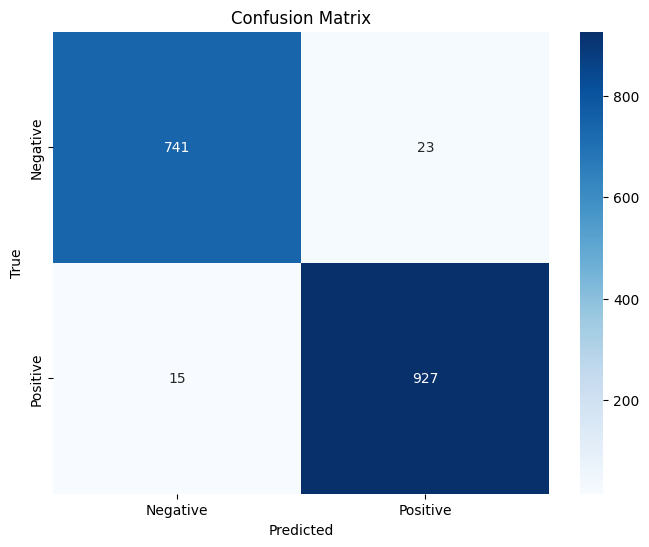

In [25]:
# Assuming you have the results_df DataFrame available
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
true_labels = results_df['True Value'].tolist()
predicted_labels = results_df['Predicted Value'].tolist()
confusion = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(confusion, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Open the File that contains metadata about the content

In [26]:
point_label_path = "/content/drive/My Drive/Project_cs210/pointlabel.txt"
# Open the file and read its contents
with open(point_label_path, "r") as file:
    data = file.read()

# Convert the data into a list of dictionaries
data_list = eval(data)

# Create a DataFrame from the list of dictionaries
df_2 = pd.DataFrame(data_list)

In [27]:
df_2.head()

,File Name,Folder,Source,Date,Perf,direction,point
0,haberler_1.7.2020.txt,neg,haberler,01.07.2020,-1.58,1,1.58
1,haberler_10.12.2021.txt,neg,haberler,10.12.2021,0.09,-1,-0.09
2,haberler_10.5.2023.txt,neg,haberler,10.05.2023,-1.10,1,1.10
3,haberler_11.10.2022.txt,neg,haberler,11.10.2022,-0.52,1,0.52
4,haberler_12.4.2021.txt,neg,haberler,12.04.2021,-1.26,1,1.26


In [41]:
results_df.head()

,Content,File Name,True Value,Predicted Value
0,BIST-100 dün yatay kapanış gerçekleştirdi. Haf...,akbank_28.04.2023_18.txt,0,0
1,Piyasa dün beklentiler paralelinde sert bir dü...,akbank_23.03.2021_522.txt,0,0
2,"Dün özellikle telekom, banka ve savunma sanayi...",akbank_25.11.2021_362.txt,0,1
3,Geçtiğimiz hafta Covid-19a ilişkin endişeler ...,akbank_01.02.2021_558.txt,0,1
4,Geçtiğimiz hafta küresel piyasalarda risk işta...,akbank_13.09.2021_413.txt,0,0


## Save results into json for Outer visualizations

In [43]:
results_df.to_json('results_data.json', orient='records')


In [30]:
merged_df = pd.merge(results_df, df_2, on='File Name')

In [39]:
merged_df.head()

,Content,File Name,True Value,Predicted Value,Folder,Source,Date,Perf,direction,point
1634,Borsa İstanbul'un en çok kar sağlayan sektörü ...,haberler_30.6.2020.txt,1,1,pos,haberler,2020-06-30,0.09,1,0.09
726,BIST 30 Endeksi'nde açığa satış yasağı kaldırıldı,haberler_1.7.2020.txt,0,0,neg,haberler,2020-07-01,-1.58,1,1.58
724,Borsa günün ilk yarısında yatay seyretti,haberler_3.7.2020.txt,0,0,neg,haberler,2020-07-03,-1.34,1,1.34
1604,Borsa İstanbul'dan tüm zamanların işlem hacmi ...,haberler_7.7.2020.txt,1,1,pos,haberler,2020-07-07,0.46,1,0.46
739,Avrupa borsaları karışık açıldı,haberler_9.7.2020.txt,0,0,neg,haberler,2020-07-09,-2.98,1,2.98


## Drop analysis columns made with true labels

In [53]:
final_df = merged_df.drop([ 'Perf', 'direction', 'point'], axis = 1)

In [54]:
final_df.dtypes

Content                    object
File Name                  object
True Value                  int64
Predicted Value             int64
Folder                     object
Source                     object
Date               datetime64[ns]
dtype: object

In [55]:
# Sort data by Date
final_df['Date'] = pd.to_datetime(final_df['Date'], format='%d.%m.%Y')
final_df.sort_values('Date', inplace=True)

In [56]:
final_df.head()

,Content,File Name,True Value,Predicted Value,Folder,Source,Date
1634,Borsa İstanbul'un en çok kar sağlayan sektörü ...,haberler_30.6.2020.txt,1,1,pos,haberler,2020-06-30
726,BIST 30 Endeksi'nde açığa satış yasağı kaldırıldı,haberler_1.7.2020.txt,0,0,neg,haberler,2020-07-01
724,Borsa günün ilk yarısında yatay seyretti,haberler_3.7.2020.txt,0,0,neg,haberler,2020-07-03
1604,Borsa İstanbul'dan tüm zamanların işlem hacmi ...,haberler_7.7.2020.txt,1,1,pos,haberler,2020-07-07
739,Avrupa borsaları karışık açıldı,haberler_9.7.2020.txt,0,0,neg,haberler,2020-07-09


In [81]:
# Extract rows for May 2022
filtered_df = final_df[(final_df['Date'].dt.year == 2022) & (final_df['Date'].dt.month == 5) & final_df['Source'] == 'haberler']

print(filtered_df)


Empty DataFrame
Columns: [Content, File Name, True Value, Predicted Value, Folder, Source, Date, Year, YearMonth]
Index: []


## Start Visualizing
- General Visulizations concerning of the predictions will be made here
- Visualizations concerning the suitability of the predictions with the Stock data can be seen in the pptx file

In [57]:
df_grouped = final_df.groupby(['Source', 'Predicted Value'])
df_grouped.describe()

True Value                                          \
                               count      mean       std  min  25%  50%  75%   
Source    Predicted Value                                                      
akbank    0                    337.0  0.011869  0.108459  0.0  0.0  0.0  0.0   
          1                    227.0  0.955947  0.205666  0.0  1.0  1.0  1.0   
garanti   0                    117.0  0.034188  0.182493  0.0  0.0  0.0  0.0   
          1                    148.0  0.993243  0.082199  0.0  1.0  1.0  1.0   
gedik     0                     81.0  0.024691  0.156150  0.0  0.0  0.0  0.0   
          1                     69.0  0.942029  0.235401  0.0  1.0  1.0  1.0   
haberler  0                     58.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
          1                    148.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
yapikredi 0                    149.0  0.033557  0.180693  0.0  0.0  0.0  0.0   
          1                    332.0  0.975904  0.153580  0.0  1.0  1.0  1.0   

                                
                           max  
Source    Predicted Value       
akbank    0                1.0  
          1                1.0  
garanti   0                1.0  
          1                1.0  
gedik     0                1.0  
          1                1.0  
haberler  0                0.0  
          1                1.0  
yapikredi 0                1.0  
          1                1.0

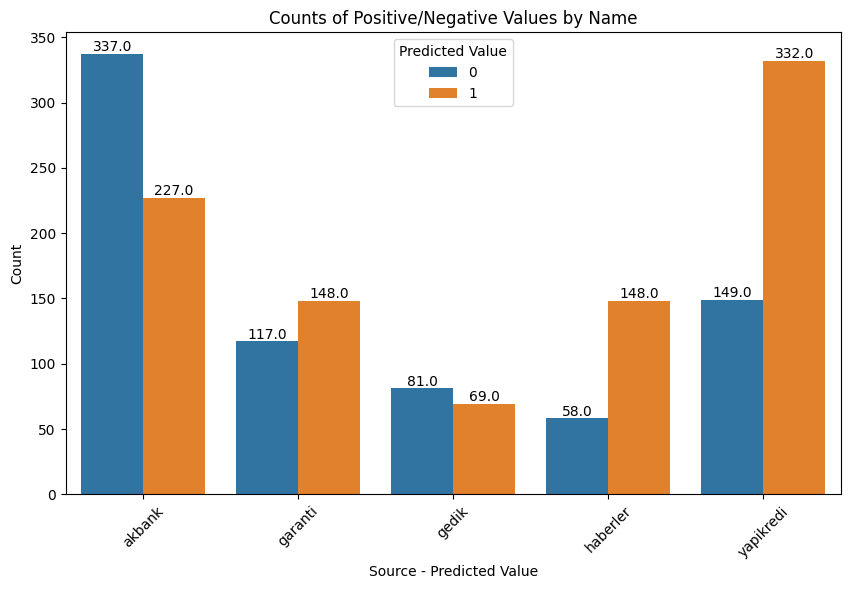

In [65]:
import seaborn as sns
import pandas as pd
import numpy as np

# Compute counts for each group and percentage for each Name
df_count = final_df.groupby(['Source', 'Predicted Value']).size().reset_index(name='size')
df_count['total_size'] = df_count.groupby('Source')['size'].transform('sum')
df_count['percentage'] = df_count['size'] * 100 / df_count['total_size']

# Create a palette for the unique names
palette = sns.color_palette("tab10", len(df_count['Source'].unique()))

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Source", y="size", hue="Predicted Value", data=df_count, palette=palette)

# Annotate the bars with the percentage values
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Set the labels and title
ax.set_xlabel('Source - Predicted Value')
ax.set_ylabel('Count')
ax.set_title('Counts of Positive/Negative Values by Name')

# Show the bar graph
plt.show()


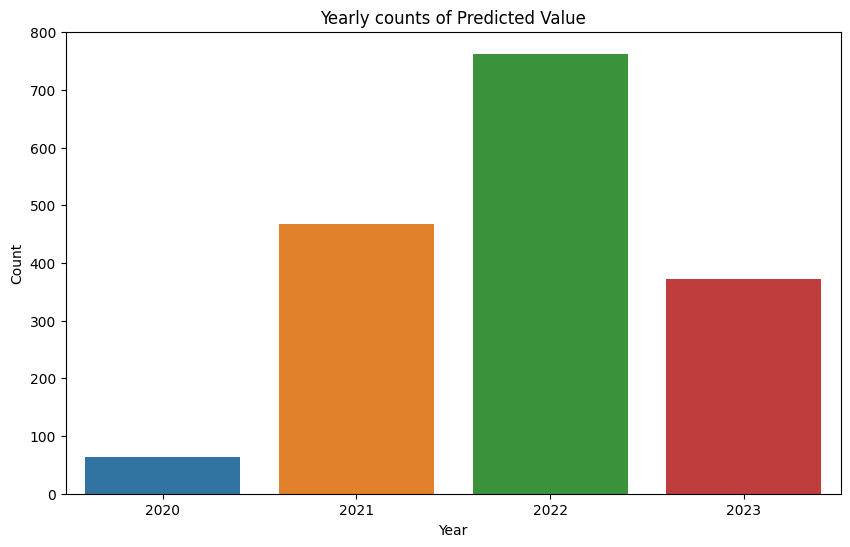

In [67]:
# Extract the year from the 'Date' column
final_df['Year'] = final_df['Date'].dt.year

# Count the 'Predicted Value' for each year
yearly_predicted_counts = final_df.groupby('Year')['Predicted Value'].count().reset_index()

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='Year', y='Predicted Value', data=yearly_predicted_counts)
plt.title('Yearly counts of Predicted Value')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


## Heatmaps per source
- no review shared for the month if data is not present
- Haberler is excluded since the aim of haberler was to get simple training examples

<ipython-input-87-00febc60ad6f>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = positive_percentages.pivot('Source', 'YearMonth', 'PositivePercentage')


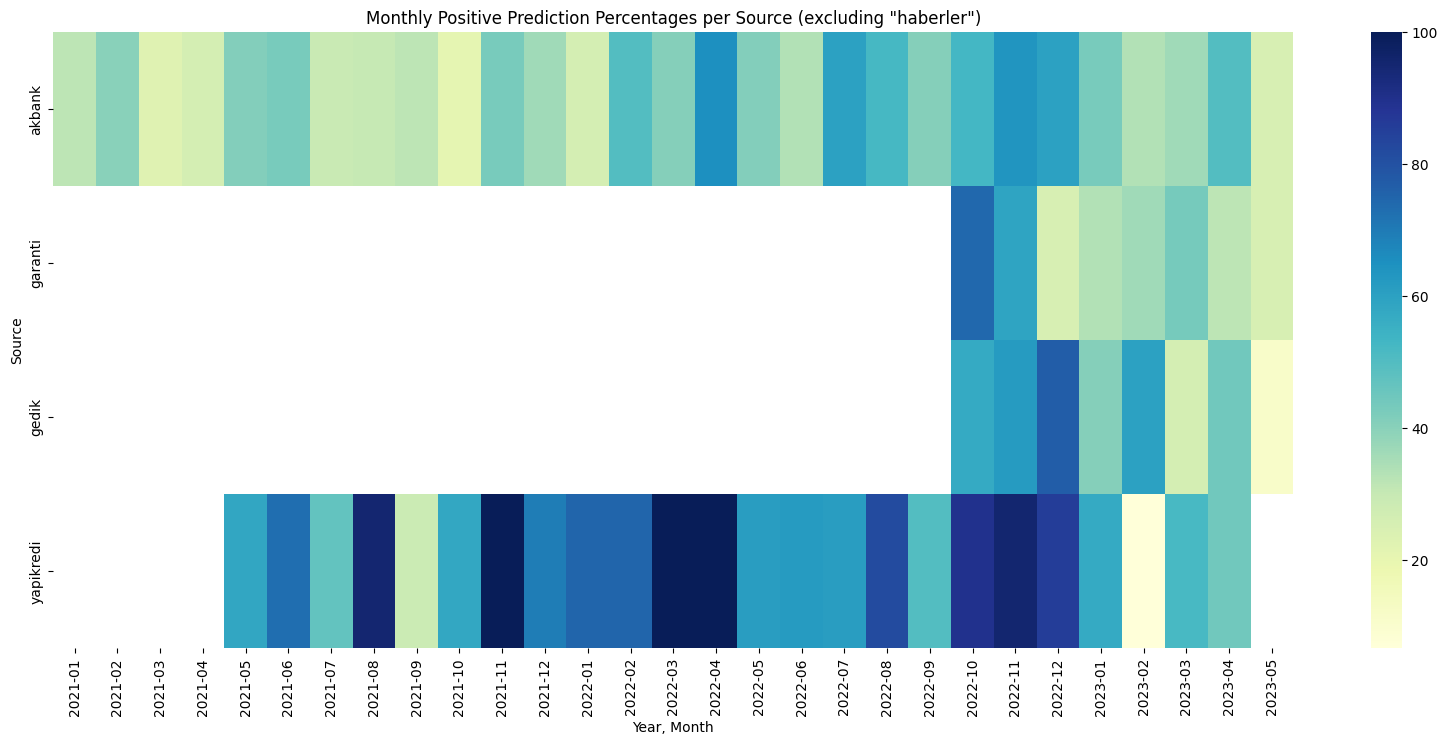

In [87]:
# Extract the year and month from the 'Date' column
final_df['YearMonth'] = final_df['Date'].dt.to_period('M')

# Filter out the "haberler" source
filtered_df = final_df[final_df['Source'] != 'haberler']

# Get the total counts and positive counts for each 'YearMonth' and 'Source'
total_counts = filtered_df.groupby(['YearMonth', 'Source']).size()
positive_counts = filtered_df[filtered_df['Predicted Value'] == 1].groupby(['YearMonth', 'Source']).size()

# Calculate the positive prediction percentages
positive_percentages = (positive_counts / total_counts * 100).reset_index(name='PositivePercentage')

# Pivot the data for the heatmap
heatmap_data = positive_percentages.pivot('Source', 'YearMonth', 'PositivePercentage')

# Plotting
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Monthly Positive Prediction Percentages per Source (excluding "haberler")')
plt.xlabel('Year, Month')
plt.ylabel('Source')
plt.show()


<ipython-input-85-c7082fe7a3e8>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = negative_percentages.pivot('Source', 'YearMonth', 'NegativePercentage')


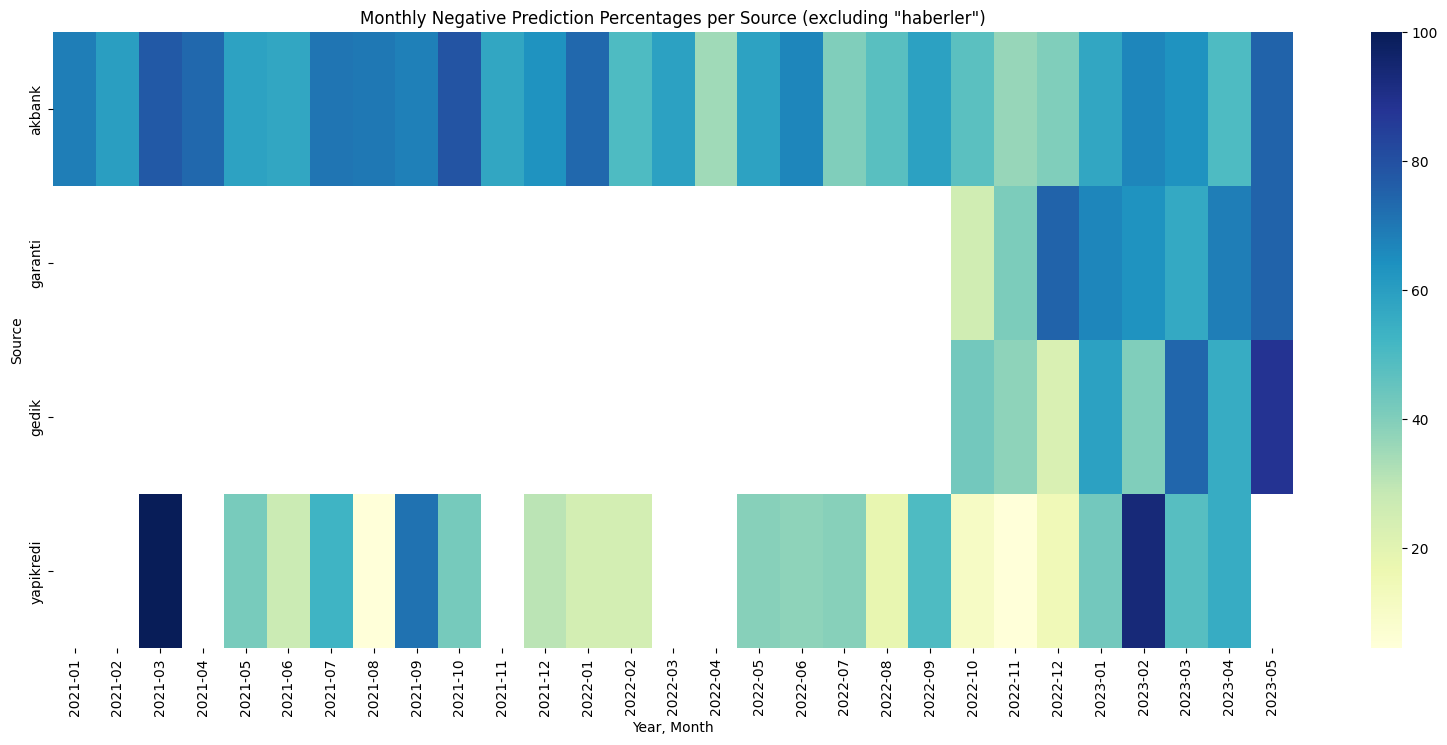

In [85]:
# Extract the year and month from the 'Date' column
final_df['YearMonth'] = final_df['Date'].dt.to_period('M')

# Filter out the "haberler" source
filtered_df = final_df[final_df['Source'] != 'haberler']

# Get the total counts and negative counts for each 'YearMonth' and 'Source'
total_counts = filtered_df.groupby(['YearMonth', 'Source']).size()
negative_counts = filtered_df[filtered_df['Predicted Value'] == 0].groupby(['YearMonth', 'Source']).size()

# Calculate the negative prediction percentages
negative_percentages = (negative_counts / total_counts * 100).reset_index(name='NegativePercentage')

# Pivot the data for the heatmap
heatmap_data = negative_percentages.pivot('Source', 'YearMonth', 'NegativePercentage')

# Plotting
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Monthly Negative Prediction Percentages per Source (excluding "haberler")')
plt.xlabel('Year, Month')
plt.ylabel('Source')
plt.show()
